<a href="https://colab.research.google.com/github/w95wayne10/personal_financial_management/blob/master/DH_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A hedger is short 10,000 European calls.  
As an option covers 100 shares of stock, N = 1,000,000.  


0 3 6 3

In [56]:
import numpy as np
np.set_printoptions(suppress=True)#, threshold=np.nan)

In [45]:
# 2: 0: 0.41631 and 0.46255
path = [ 
 {0:(0.7225, 0.50397)},
 {-3:(0.1726,0.19247),0:(0.55274,0.50304),3:(1.39859,0.81218)},
 {-6:(0.0,0.0), -3:(0.0, 0.0), 0:(0.41631, 0.50304), 3:(1.22372, 1.0), 6:(2.46242, 1.0)},
 {-9:(0, 1.0), -6:(0,1.0), -3:(0, 1.0), 0:(0.0, 1.0), 3:(1.22372, 1.0), 6:(2.46242, 1.0), 9:(3.71628, 1.0)}
]

In [ ]:
#yt1 = yt0 + r - ht**2/2 + ht*epsilon
#Monte Carlo
S = 100
y0 = np.log(S)
yt = y0
h=np.sqrt(10.96/1e5)
#np.random.seed(1)
#print(np.exp(yt), h**2*1e5)
price_path = []
price_path.append(S)
for t in range(3):
  eps = np.random.standard_normal(1)[0]
  yt = yt - h**2/2 + h*eps
  h = np.sqrt(0.000006575 + 0.9*h**2 + 0.04*h**2*eps**2)
  price_path.append(np.exp(yt))
  #print(np.exp(yt), h**2*1e5, eps)
node_path = []
for idx, p in enumerate(price_path):
  a = idx*2+1
  b = a//2
  node_path.append(int((np.argmin(np.abs(p - np.exp(np.log(100)+(np.arange(a)-b)*3*np.sqrt(0.00006575)/2)))-b)*3))
node_path = np.array(node_path)
price_path = np.array(price_path)
node_path, price_path

(array([ 0,  0, -3,  0]),
 array([100.        ,  99.65756901,  99.25965841, 100.39932985]))

In [ ]:
#hedge
S = 100
N = 1000000
node_index = node_path.copy()
y = np.log(S)+node_index*np.sqrt(0.00006575)/2
S = np.exp(y)
temp = []
for idx, node in enumerate(node_index):
  temp.append(path[idx][node])
f,delta = list(zip(*temp))
f = np.array(f)
delta = np.array(delta)
change_delta = delta.copy()
change_delta[1:] = delta[1:]-delta[:-1]
shares_bought = N*change_delta
cost_shares = S*shares_bought
cumulative_cost = np.cumsum(cost_shares)
cumulative_cost[-1] - N*S[0]

608139.4574503154

772069.7404237986

數量加大

In [59]:
sample_size = 1000
np.random.seed(1)
EPS = np.random.standard_normal((sample_size,3))
#yt1 = yt0 + r - ht**2/2 + ht*epsilon
#Monte Carlo
S = 100
y0 = np.log(S)
YT = np.zeros((sample_size,4))
YT[:,0] = y0
h = np.sqrt(10.96/1e5)
H = np.zeros((sample_size,4))
H[:,0] = h
PRICE_PATH = np.zeros((sample_size,4))
PRICE_PATH[:,0] = S
for t in range(3):
  YT[:,t+1] = YT[:,t]-H[:,t]**2/2 + H[:,t]*EPS[:,t]
  H[:,t+1] = np.sqrt(0.000006575 + 0.9*H[:,t]**2 + 0.04*H[:,t]**2*EPS[:,t]**2)
  PRICE_PATH[:,t+1] = np.exp(YT[:,t+1])
b = np.arange(4)
a = b*2+1
NODE_PATH = np.zeros((sample_size,4))
for t in range(4):
  NODE_PART = np.tile(np.exp(np.log(100)+(np.arange(a[t])-b[t])*3*np.sqrt(0.00006575)/2),(sample_size,1))
  REAL_PART = np.tile(PRICE_PATH[:,t].reshape((sample_size,1)),(1,a[t]))
  NODE_PATH[:,t] = (np.argmin(np.abs(REAL_PART - NODE_PART),axis= 1)-b[t])*3
NODE_PATH

array([[ 0.,  3.,  3.,  0.],
       [ 0., -3.,  0., -6.],
       [ 0.,  3.,  3.,  3.],
       ...,
       [ 0.,  3.,  3.,  3.],
       [ 0., -3., -6., -9.],
       [ 0.,  0., -3., -6.]])

In [72]:
#hedge
S = 100
N = 1000000
NODE_INDEX = NODE_PATH.copy()
S = PRICE_PATH#np.exp(y)
F = np.zeros((sample_size,4))
DELTA = np.zeros((sample_size,4))
for t in range(4):
  temp = np.array([path[t][NODE_INDEX[i,t]] for i in range(sample_size)])
  F[:,t] = temp[:,0]
  DELTA[:,t] = temp[:,1]
CHANGE_DELTA = DELTA.copy()
CHANGE_DELTA[:, 1:] = DELTA[:, 1:]-DELTA[:, :-1]
SHARES_BOUGHT = N*CHANGE_DELTA
COST_SHARES = S*SHARES_BOUGHT
CUMULATIVE_COST = np.cumsum(COST_SHARES, axis=1)
result = N*F[:,0] - (CUMULATIVE_COST[:, -1] - N*S[:,0])

In [73]:
result.mean(),result.var()**0.5

(679296.817464429, 983404.903775845)

In [74]:
import matplotlib.pyplot as plt

<a list of 83 Patch objects>

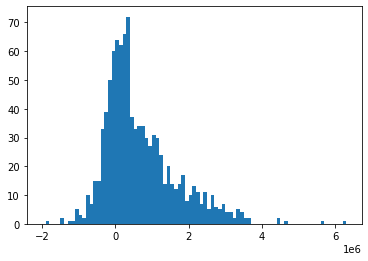

In [88]:
plt.hist(result,np.arange(-20,64)*1e5)[2]